## Playground for PDDNet
The class below was taken from the git repo https://github.com/multimodallearning/pdd_net

This is the playgrund for PDD exploration and creating a model, that will be used as a student with FLowNet2 and PWC-Net as teachers

In [69]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
from utils.plotting import countParameters, flow2img, overlaySegment
from utils.layers import warp
from utils.encoding import labelMatrixOneHot

import cv2
from utils.layers import warp 
from ptflops import get_model_complexity_info

In [71]:
img = torch.load("Data/img.pth")
seg= torch.load("Data/seg.pth")

In [75]:
h, w = img[0].shape
print(h,w)
o_m = h//3
o_n = w//3
#o_o = D//3
#print('numel_o',o_m*o_n)
ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,o_m,o_n)).view(1,1,-1,2)#.cuda()
print("ogrid_xy: ", ogrid_xy.shape)

disp_range = 0.25#0.25
displacement_width = 11#15#11#17
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2)#.cuda()
print("shift: ", shift_xy.shape)

#_,_,H,W,D = img00.size()
grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2)#.cuda()
print("grid: ", grid_xy.shape)

320 256
ogrid_xy:  torch.Size([1, 1, 9010, 2])
shift:  torch.Size([1, 1, 121, 2])
grid:  torch.Size([1, 1024, 1, 2])


Basically I reduced every dimension as far as I could by 1. This does $\textbf{not}$ mean that this isthe right way to do it. I need to look into the logic behind it

## Obelisk and Deeds 2D 

In [4]:
class OBELISK2d(nn.Module):
    def __init__(self, chan = 16):

        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2,channels*2)*0.05)
        self.layer0 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels*4, channels*4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels*4)
        self.layer2 = nn.Conv2d(channels*4, channels*2, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels*2)
        self.layer3 = nn.Conv2d(channels*2, channels*1, 1)


    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img,3,padding=1,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in,ogrid_xy + self.offsets[0,:].view(1,-1,1,2)).view(1,-1,o_m,o_n)
        sampled -= F.grid_sample(img_in,ogrid_xy + self.offsets[1,:].view(1,-1,1,2)).view(1,-1,o_m,o_n)
    
        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features


class deeds2d(nn.Module):
    def __init__(self):

        super(deeds2d, self).__init__()
        self.alpha = nn.Parameter(torch.Tensor([1,.1,1,1,.1,1])).cuda()

        self.pad1 = nn.ReplicationPad2d(3).cuda()
        self.avg1 = nn.AvgPool2d(3,stride=1).cuda()
        self.max1 = nn.MaxPool2d(3,stride=1).cuda()
        self.pad2 = nn.ReplicationPad2d(2).cuda()##
        
    def forward(self, feat00,feat50):
        
        #deeds correlation layer (slightly unrolled)
        deeds_cost = torch.zeros(1,grid_size**2,displacement_width, displacement_width).cuda()

        #print(deeds_cost.shape)
        xy8 = grid_size**2
        #i=1
        #print(grid_xy[:,i*grid_size:(i+1)*grid_size,:,:].shape)
        for i in range(grid_size): 
            moving_unfold = F.grid_sample(feat50, grid_xy[:,i*grid_size:(i+1)*grid_size,:,:] + shift_xy,padding_mode='border')
            fixed_grid = F.grid_sample(feat00, grid_xy[:,i*grid_size:(i+1)*grid_size,:,:]) # grid_xy[:,i*xy8:(i+1)*xy8,:,:]
            deeds_cost[:,i*grid_size:(i+1)*grid_size,:,:] = self.alpha[1]+self.alpha[0]*torch.sum(torch.pow(fixed_grid-moving_unfold,2),1).view(1,-1,displacement_width,displacement_width)
        

        # remove mean (not really necessary)
        #deeds_cost = deeds_cost.view(-1,displacement_width**3) - deeds_cost.view(-1,displacement_width**3).mean(1,keepdim=True)[0]
        #deeds_cost = deeds_cost.view(1,-1,displacement_width,displacement_width)
        #print(deeds_cost.shape)

        # approximate min convolution / displacement compatibility
        cost = self.avg1(self.avg1(-self.max1(-self.pad1(deeds_cost))))            
        # grid-based mean field inference (one iteration)
        cost_permute = cost.permute(2,3,0,1).view(1,displacement_width**2,grid_size, grid_size)
        cost_avg = self.avg1(self.avg1(self.pad2(cost_permute))).permute(0,2,3,1).view(1,-1,displacement_width,displacement_width)

        # second path
        cost = self.alpha[4]+self.alpha[2]*deeds_cost+self.alpha[3]*cost_avg
        cost = self.avg1(self.avg1(-self.max1(-self.pad1(cost))))
        
        # grid-based mean field inference (one iteration)
        cost_permute = cost.permute(2,3,0,1).view(1,displacement_width**2,grid_size,grid_size)
        cost_avg = self.avg1(self.avg1(self.pad2(cost_permute))).permute(0,2,3,1).view(grid_size**2,displacement_width**2)
        #cost = alpha[4]+alpha[2]*deeds_cost+alpha[3]*cost.view(1,-1,displacement_width,displacement_width,displacement_width)
        #cost = avg1(avg1(-max1(-pad1(cost))))
        
        #probabilistic and continuous output
        cost_soft = F.softmax(-self.alpha[5]*cost_avg,1)
        #pred_xyz = torch.sum(F.softmax(-5self.alpha[2]*cost_avg,1).unsqueeze(2)*shift_xyz.view(1,-1,3),1)
        pred_xy = torch.sum(cost_soft.unsqueeze(2)*shift_xy.view(1,-1,2),1)


        return cost_soft,pred_xy

In [6]:
net = OBELISK2d(chan=10).cuda()
#reg = deeds2d().cuda()

macs_obel, params_obel = get_model_complexity_info(net, input_res=(1,320,256), as_strings=True,
                                           print_per_layer_stat=True, verbose=True)
print('{:<30}  {:<8}'.format('Computational complexity: ', macs_obel))
print('{:<30}  {:<8}'.format('Number of parameters: ', params_obel))

OBELISK2d(
  0.009 M, 99.569% Params, 0.083 GMac, 100.000% MACs, 
  (layer0): Conv2d(0.0 M, 1.078% Params, 0.001 GMac, 0.618% MACs, 1, 4, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
  (batch0): BatchNorm2d(0.0 M, 0.086% Params, 0.0 GMac, 0.049% MACs, 4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Conv2d(0.002 M, 17.245% Params, 0.014 GMac, 17.408% MACs, 40, 40, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (batch1): BatchNorm2d(0.0 M, 0.862% Params, 0.001 GMac, 0.870% MACs, 40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Conv2d(0.007 M, 77.603% Params, 0.065 GMac, 78.334% MACs, 40, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (batch2): BatchNorm2d(0.0 M, 0.431% Params, 0.0 GMac, 0.435% MACs, 20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Conv2d(0.0 M, 2.263% Params, 0.002 GMac, 2.285% MACs, 20, 10, kernel_size=(1, 1), stride=(1, 1))
)
Computatio

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


MAC stands for *Multiply–accumulate operation* and can be roughly interpreted as GMACs = 0.5 * GFLOPs $\Leftrightarrow$ 2 * GMACs = GFLOPs 

From "AutoDVT" by Tanno et al, we knwo, that the PowerVR GT7600 Plus (a mobile GPU) provides up to 384 GFLOPs. devided by 25 images/s (leave room for other processes on the GPU), this yields $\frac{384 GFLOPs}{25 IMGs} \approx 15GFLOP$ for one image pass.

With the api, used in the cell above, we can estimate the GFLOPs of the used model. By multiplying the estimated GMac by 2 to convert it into FLOP we get $0.16 * 2 * 2 = 0.32$ GFLOP for one images for the feature extraction. We only need to estmate this for one image, as the feature extracted from the previous frame can be held in memory and does not need to be computed twice. Passing through two images, will only need to be done in the beginning, when there is no feature representation existend in memory.

Now the reg model, is a bit more difficult. The api used above, only allows for one input resolution, and therefore can't be used with the reg model, as it expects two inputs. However, we can roughly estimate the FLOP used by the reg model, when we think about what is happening. We first estimate the correlation between the two extracted features for every grid point. Both features have a size of BxOutputChannelx106x85, with B = 1. With a grid size of 32x32, we loop over the correlation estimation 32 times. The correlation estimation can be expressed as $\alpha_1 + \alpha_0 * \sum_{c=0}^{Channel}(fixed-moving)^2$ where fixed has a shape of Channel x Grid x 1 and moving Channel x Grid x Offset². We need to do gridsize x displacement² subtractions and multiplications. This is done over the Channels in every grid. We end up with grid x Channel x (grid x displacement²)² Flop. For 14 channels and a grid of 32 x 32 with an displacement of 11, we end up with $32 * 14 * (32 * 121)^2 = 6.716.588.032$ operations. This would be 6.7 GFlop for one pass. *And I am honestly not sure about this...*

Alternative: $32 * 14 * (32 * 121) = 1734656$


In [7]:
image = img[0].cuda()
segmen = seg[0].float().cuda()

In [8]:
net = OBELISK2d(chan=10).cuda()
with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA],
    with_flops=True,
    profile_memory=True,
    
) as p:
    output = net(image.reshape(1,h,w).unsqueeze(0).to(torch.float32))
    output = net(image.reshape(1,h,w).unsqueeze(0).to(torch.float32))
    cost_out, pred = reg(output.cuda(), output.cuda())
print(p.key_averages().table(
    sort_by="self_cuda_time_total"))

NameError: name 'reg' is not defined

If I read this correctly, the network takes around 3.1 ms on a GTX 1060 and requires $857.424 + 904.664 + 1273041.118 = 1.274.803.206$ MFlops

If the numver of channels is reduced to 10, the runtime is abviously lower

torch.Size([1, 56, 106, 85])


ValueError: x and y must be the same size

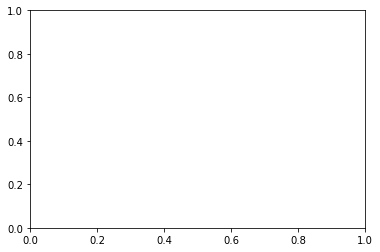

In [15]:
time_array = []
for i in range(1):
    begin = time.time()
    output = net(image.reshape(1,h,w).unsqueeze(0).to(torch.float32))
    cost_out, pred = reg(output, output)
    end = time.time()
    time_array.append(end-begin)
#print(f"Total runtime of the Obelisk Net is {(end - begin)} for one image \nThat means {25*(end - begin)} for 25 images")
plt.scatter(np.arange(1000), time_array)

In [72]:
print("Mean inference time: ", np.asarray(time_array).mean())
print("Variance: ", np.asarray(time_array).var())

Mean inference time:  0.03438071346282959
Variance:  1.955802822584701e-06


Mean infeence time is around 0.034 seconds. Some variance, as seen in the plot. Might be due to background programs

In [17]:
cost_out, pred = reg(output, output)
print(pred.view(grid_size,grid_size,2).shape)
print(cost_out.shape)

torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([1, 14, 32, 121])
torch.Size([32, 32, 2])
torch.Size([1024, 121])


In [8]:
resized = cv2.resize(pred.reshape(grid_size,grid_size,2).detach().numpy(),(h,w))
flow_img = flow2img(resized)

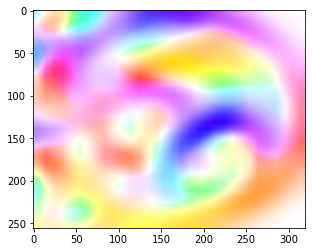

In [9]:
plt.imshow(flow_img)

Obviously this is nonesense, but the flow is there.. not sure about the upscaling though..

In [10]:
# NOT SURE about this cell. If it does any good

segmen_grid = F.grid_sample(segmen.unsqueeze(0).unsqueeze(0),grid_xy+shift_xy,padding_mode='border')
print(segmen_grid.shape)
print(cost_out.view(1,-1,grid_size**2,displacement_width**2).shape)
warped = segmen_grid * cost_out.view(1,-1,grid_size**2,displacement_width**2)
#warped_label = (F.grid_sample(segmen.unsqueeze(0).unsqueeze(0),grid_xy+shift_xy,padding_mode='border') *cost_out.view(1,-1,grid_size**2,displacement_width**2)).sum(3,keepdim=True)

torch.Size([1, 1, 1024, 121])
torch.Size([1, 1, 1024, 121])


## Train the network for 2D Input

In [12]:
def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

def augmentAffine(img_in, seg_in, strength=0.05):
    """
    3D affine augmentation on image and segmentation mini-batch on GPU.
    (affine transf. is centered: trilinear interpolation and zero-padding used for sampling)
    :input: img_in batch (torch.cuda.FloatTensor), seg_in batch (torch.cuda.LongTensor)
    :return: augmented BxCxTxHxW image batch (torch.cuda.FloatTensor), augmented BxTxHxW seg batch (torch.cuda.LongTensor)
    """
    B,C,H,W = img_in.size()
    affine_matrix = (torch.eye(2,3).unsqueeze(0) + torch.randn(B, 2, 3) * strength)#.to(img_in.device)

    meshgrid = F.affine_grid(affine_matrix,torch.Size((B,1,H,W)))

    img_out = F.grid_sample(img_in.float(), meshgrid,padding_mode='border')
    seg_out = F.grid_sample(seg_in.float().unsqueeze(1), meshgrid, mode='nearest').long().squeeze(1)

    return img_out, seg_out

In [106]:
def correlation_layer(displace_range, feat_moving, feat_fixed):
    # tensor dimensionalities in comments are for an arbitrary choice of
    # displace_range = 11 & feat sizes of [1,24,80,78];
    # they clearly depend on the actual choice and only serve as numerical examples here.

    disp_hw = (displace_range -1 )//2
    # feat_mov: [1,24,80,78] -> 24 feature channels + spatial HW dims
    # feat_mov_unfold: [24,121,6240] -> mind chans, 11*11 = 121 displ steps, 6240 = 80*78 spatial positions
    feat_moving_unfold = F.unfold(feat_moving.transpose(1 ,0) ,(displace_range ,displace_range) ,padding=disp_hw)

    B ,C ,H ,W = feat_fixed.size()

    # feat_fixed: [24,1,6240] -> compute scalarproduct along feature dimension per broadcast + sum along 0
    # and reshape to [1,121,80,78]
    ssd_distance = ((feat_fixed.view(C ,1 ,-1) - feat_moving_unfold )**2).sum(0).view(1 ,displace_range**2 ,H ,W)
    # reshape the 4D tensor back to spatial dimensions
    return ssd_distance

def meanfield(ssd_distance ,img_fixed ,displace_range ,H ,W):

    # crnt_dev = ssd_distance.device


    cost = min_convolution(ssd_distance, displace_range, H, W)
    # probabilistic output: compute the contributions weights of every discrete displacement pair for all positions
    # along 121 possible xy displacements -> normalize to [0,1] with softmax:
    # in order to have the lowest SSD value as the "max" 1 value, multiply it with -10 beforehand

    # therefore apply the softmax along the displacement dimension
    # reshaping the cost tensor as follows: [1,121,H,W] -> [121, H*W] -> [H*W,121] : perform softmax along dim 1
    soft_cost = F.softmax(-10 *cost.view(displace_range**2 ,-1).t() ,1)
    # calculate displacement field (could be shorted when stacking x,y - but less intuitive)
    # idea: 1) construct a meshgrid of all discrete displacement pairs per position
    #       2) use broadcasting to get the weighted contributions of all displacement values (separated for x&y)
    #          (soft_cost) [H*W,121] x [1,121] (xs,ys) : sum along dim 1 -> [H*W] -> reshape [H,W]

    disp_hw = (displace_range -1 )//2
    xs ,ys = torch.meshgrid(torch.arange(-disp_hw ,disp_hw +1).float(),
                           torch.arange(-disp_hw ,disp_hw +1).float())

    disp_x = (soft_cost *xs.reshape(1 ,-1)).sum(1).data.reshape(H ,W)#.cpu()
    disp_y = (soft_cost *ys.reshape(1 ,-1)).sum(1).data.reshape(H ,W)#.cpu()
        
    # resample field to high resolution and add identity transform

    # this factor is used to resize the displacements to a valid range since the CNN architecture
    # downsamples the input images by a factor of 4
    scale_factor = 4

    # since so far only the position-wise displacements are computed, we also need to prepare the identity field
    # in order to warp the moving images correctly
    x ,y = torch.meshgrid(torch.arange(0 ,img_fixed.size(2)).float(),
                         torch.arange(0 ,img_fixed.size(3)).float())

    # before adding the displacements and the identity transform, the displacements need to be scaled according to
    # the original image dimensionality (so far computed on the 4x downsampled feature maps)
    disp_xy_up = scale_factor *F.interpolate(torch.stack((disp_x ,disp_y) ,0).cpu().unsqueeze(0),
                                            size=(img_fixed.size(2) ,img_fixed.size(3)),
                                            mode='bicubic')
    xi = x + disp_xy_up[0 ,0 ,: ,:]
    yi = y + disp_xy_up[0 ,1 ,: ,:]
    
    return soft_cost, disp_xy_up  # ,xi,yi

def min_convolution(ssd_distance, displace_range, H, W):
    # Prepare operators for smooth dense displacement space
    pad1 = nn.ReplicationPad2d(5)
    avg1 = nn.AvgPool2d(5 ,stride=1)
    max1 = nn.MaxPool2d(3 ,stride=1)
    pad2 = nn.ReplicationPad2d(6)
    # approximate min convolution / displacement compatibility

    # 1) switch dimensions in order to get per HW position the displacement with "highest correlation" by
    # means of lowest SSD
    # therefore, swap the dimensions of the tensor in order to make the pooling operations work along the
    # displacement search region: [1,121,80,78] -> [1,80,78,121] -> [1,80*78,11,11] = [1,6240,11,11]
    # using appropriate padding, -max(-x) u get the min value and 2x avg-pooling afterwards for quadratic smoothing
    ssd_minconv = avg1(avg1(-max1(-pad1(ssd_distance.permute(0 ,2 ,3 ,1).reshape(1 ,-1 ,displace_range ,displace_range)))))

    # 2)reconstruct the spatial arangement [1,121,80,78] and perform the spatial mean-field inference under valid padding
    ssd_minconv = ssd_minconv.permute(0 ,2 ,3 ,1).view(1 ,-1 ,H ,W)
    min_conv_cost = avg1(avg1(avg1(pad2(ssd_minconv))))

    return min_conv_cost

In [107]:
torch.manual_seed(10)

pat_indices = torch.cat((torch.arange(0, 17), torch.arange(18, 43)), 0)

rnd_perm_idc = torch.randperm(pat_indices.size(0))
pat_indices = pat_indices[rnd_perm_idc]
# train_set = pat_indices[:35]
# test_set = torch.cat((pat_indices[35:],torch.LongTensor([17])),0)

# Now, we prepare our train & test dataset.
test_set = torch.LongTensor([35, 41, 0, 4, 33, 38, 39, 17])
train_set = torch.arange(43)
for idx in test_set:
    train_set = train_set[train_set != idx]

print('Test_Set:', test_set)
print('Train_Set:', train_set)

Test_Set: tensor([35, 41,  0,  4, 33, 38, 39, 17])
Train_Set: tensor([ 1,  2,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20,
        21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 36, 37, 40, 42])


In [110]:
net = OBELISK2d()
net.apply(init_weights)
net.train()
net.cuda()
#reg = deeds2d()

H, W = img[0].size()

class_weight = torch.sqrt(1.0/(torch.bincount(seg.view(-1)).float()))
class_weight = class_weight/class_weight.mean()
class_weight[0] = 0.15
#class_weight[4] /= 10
print('inv sqrt class_weight',class_weight)
criterion = nn.CrossEntropyLoss(class_weight)

epochs = 1
optimizer = torch.optim.Adam(list(net.parameters()),lr=0.05)
lambda_weight = 1.5#2#2.5#1.5
displace_range = 15
disp_hw = 5
run_labelloss = torch.zeros(epochs)#/0
run_diffloss = torch.zeros(epochs)
losses = []


def correlation_layer(displace_range, feat_moving, feat_fixed):
    # tensor dimensionalities in comments are for an arbitrary choice of
    # displace_range = 11 & feat sizes of [1,24,80,78];
    # they clearly depend on the actual choice and only serve as numerical examples here.

    disp_hw = (displace_range -1 )//2
    # feat_mov: [1,24,80,78] -> 24 feature channels + spatial HW dims
    # feat_mov_unfold: [24,121,6240] -> mind chans, 11*11 = 121 displ steps, 6240 = 80*78 spatial positions
    feat_moving_unfold = F.unfold(feat_moving.transpose(1 ,0) ,(displace_range ,displace_range) ,padding=disp_hw)

    B ,C ,H ,W = feat_fixed.size()

    # feat_fixed: [24,1,6240] -> compute scalarproduct along feature dimension per broadcast + sum along 0
    # and reshape to [1,121,80,78]
    ssd_distance = ((feat_fixed.view(C ,1 ,-1) - feat_moving_unfold )**2).sum(0).view(1 ,displace_range**2 ,H ,W)
    # reshape the 4D tensor back to spatial dimensions
    return ssd_distance

def meanfield(ssd_distance ,img_fixed ,displace_range ,H ,W):

    # crnt_dev = ssd_distance.device


    cost = min_convolution(ssd_distance, displace_range, H, W)
    # probabilistic output: compute the contributions weights of every discrete displacement pair for all positions
    # along 121 possible xy displacements -> normalize to [0,1] with softmax:
    # in order to have the lowest SSD value as the "max" 1 value, multiply it with -10 beforehand

    # therefore apply the softmax along the displacement dimension
    # reshaping the cost tensor as follows: [1,121,H,W] -> [121, H*W] -> [H*W,121] : perform softmax along dim 1
    soft_cost = F.softmax(-10 *cost.view(displace_range**2 ,-1).t() ,1)
    # calculate displacement field (could be shorted when stacking x,y - but less intuitive)
    # idea: 1) construct a meshgrid of all discrete displacement pairs per position
    #       2) use broadcasting to get the weighted contributions of all displacement values (separated for x&y)
    #          (soft_cost) [H*W,121] x [1,121] (xs,ys) : sum along dim 1 -> [H*W] -> reshape [H,W]

    disp_hw = (displace_range -1 )//2
    xs ,ys = torch.meshgrid(torch.arange(-disp_hw ,disp_hw +1).float(),
                           torch.arange(-disp_hw ,disp_hw +1).float())

    disp_x = (soft_cost *xs.reshape(1 ,-1)).sum(1).data.reshape(H ,W)#.cpu()
    disp_y = (soft_cost *ys.reshape(1 ,-1)).sum(1).data.reshape(H ,W)#.cpu()
        
    # resample field to high resolution and add identity transform

    # this factor is used to resize the displacements to a valid range since the CNN architecture
    # downsamples the input images by a factor of 4
    scale_factor = 4

    # since so far only the position-wise displacements are computed, we also need to prepare the identity field
    # in order to warp the moving images correctly
    x ,y = torch.meshgrid(torch.arange(0 ,img_fixed.size(2)).float(),
                         torch.arange(0 ,img_fixed.size(3)).float())

    # before adding the displacements and the identity transform, the displacements need to be scaled according to
    # the original image dimensionality (so far computed on the 4x downsampled feature maps)
    disp_xy_up = scale_factor *F.interpolate(torch.stack((disp_x ,disp_y) ,0).cpu().unsqueeze(0),
                                            size=(img_fixed.size(2) ,img_fixed.size(3)),
                                            mode='bicubic')
    xi = x + disp_xy_up[0 ,0 ,: ,:]
    yi = y + disp_xy_up[0 ,1 ,: ,:]
    
    return soft_cost, disp_xy_up  # ,xi,yi

def min_convolution(ssd_distance, displace_range, H, W):
    # Prepare operators for smooth dense displacement space
    pad1 = nn.ReplicationPad2d(5)
    avg1 = nn.AvgPool2d(5 ,stride=1)
    max1 = nn.MaxPool2d(3 ,stride=1)
    pad2 = nn.ReplicationPad2d(6)
    # approximate min convolution / displacement compatibility

    # 1) switch dimensions in order to get per HW position the displacement with "highest correlation" by
    # means of lowest SSD
    # therefore, swap the dimensions of the tensor in order to make the pooling operations work along the
    # displacement search region: [1,121,80,78] -> [1,80,78,121] -> [1,80*78,11,11] = [1,6240,11,11]
    # using appropriate padding, -max(-x) u get the min value and 2x avg-pooling afterwards for quadratic smoothing
    ssd_minconv = avg1(avg1(-max1(-pad1(ssd_distance.permute(0 ,2 ,3 ,1).reshape(1 ,-1 ,displace_range ,displace_range)))))

    # 2)reconstruct the spatial arangement [1,121,80,78] and perform the spatial mean-field inference under valid padding
    ssd_minconv = ssd_minconv.permute(0 ,2 ,3 ,1).view(1 ,-1 ,H ,W)
    min_conv_cost = avg1(avg1(avg1(pad2(ssd_minconv))))

    return min_conv_cost

inv sqrt class_weight tensor([0.1500, 0.1535, 0.1800, 0.3199, 7.6096, 0.0681, 0.1290, 0.2074, 0.3098])


<ipython-input-12-7d54f1414354>:3: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
<ipython-input-12-7d54f1414354>:5: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias, 0.0)


In [121]:
for i in range(epochs):
    
    idx = train_set[torch.randperm(6)].view(2,3)[:,0]
    
    optimizer.zero_grad()

    img00 = img[idx[0]:idx[0]+1,:,:].unsqueeze(0).float() / 255
    img50 = img[idx[1]:idx[1]+1,:,:].unsqueeze(0).float() / 255
    
    label_moving = seg[idx[1]:idx[1]+1,:,:].contiguous().long()
    label_fixed = seg[idx[0]:idx[0]+1,:,:].contiguous().long()
    
    moving_seg = labelMatrixOneHot(label_moving,9)
    fixed_seg = labelMatrixOneHot(label_fixed,9)

    #img00, seg50 = augmentAffine(img00_in,seg[idx[0]:idx[0]+1,:,:],0.0375)
    img00.requires_grad = True
    img50.requires_grad = True

    
    # get features (regular grid)
    feat00 = net(img00.cuda())#checkpoint(net,img00)#net(img00)# #00 is fixed
    feat50 = net(img50.cuda())#checkpoint(net,img50)#net(img50)# #50 is moving
    # run differentiable deeds (regular grid)
    # compute the cost tensor using the correlation layer
    ssd_distance = correlation_layer(displace_range, feat50.cpu(), feat00.cpu())
    
    # compute the MIN-convolution & probabilistic output with the given function
    soft_cost,pred_xy = meanfield(ssd_distance, img00, displace_range, h//3,w//3)
    # loss computation:

    #cost_soft,pred_xy =  reg(feat00,feat50)#checkpoint(reg,feat00,feat50)#reg(feat00,feat50)#
    #pred_xy = pred_xy.view(1,grid_size,grid_size,2)
    # evaluate diffusion regularisation loss
    #print(pred_xy.shape)

    
    moving_seg = F.interpolate(moving_seg,size=(h//3,w//3),mode='bilinear')
    print(moving_seg.shape)
    label_moving_unfold = F.unfold(moving_seg,(displace_range,displace_range),padding=disp_hw).view(1,9,displace_range**2,-1)
    print(label_moving_unfold.shape)
    print(soft_cost.shape)
    label_warped = torch.sum(soft_cost.cpu().t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)
    # compute the loss as sum of squared differences between the fixed label representation and the "warped" labels
    label_distance1 = torch.sum(torch.pow(label_fixed.reshape(9,-1)-label_warped.reshape(9,-1),2),0)
    loss = label_distance1.mean()
    # perform the backpropagation and weight updates
    loss.backward()
    losses.append(loss.item())
    
    optimizer.step()
    if(i%50==49):

        loss_avg = F.avg_pool1d(run_labelloss.view(1,1,-1),5,stride=1).squeeze().numpy()[:i]
        print('run_labelloss',loss_avg[-1])
        loss_avg = F.avg_pool1d(run_diffloss.view(1,1,-1),5,stride=1).squeeze().numpy()[:i]
        print('run_diffloss',loss_avg[-1])

torch.Size([1, 9, 106, 85])
torch.Size([1, 9, 225, 8262])
torch.Size([9010, 225])


RuntimeError: The size of tensor a (9010) must match the size of tensor b (8262) at non-singleton dimension 2

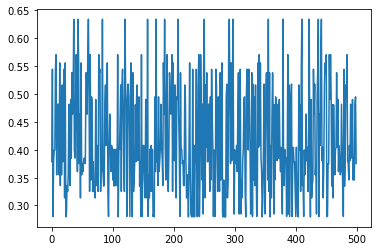

In [85]:
plt.plot(np.arange(epochs), losses)

In [15]:
random_test = test_set[torch.randperm(6)].view(2,3)[:,0]
test_img_1 = img[random_test[0]:random_test[0]+1,:,:].unsqueeze(0).float() / 255
test_img_2 = img[random_test[1]:random_test[1]+1,:,:].unsqueeze(0).float() / 255

label_1= seg[random_test[0]:random_test[0]+1,:,:]
label_2= seg[random_test[1]:random_test[1]+1,:,:]
label_2.view(h,w,-1).shape

torch.Size([320, 256, 1])

In [16]:
fixed = net(test_img_1)
moving = net(test_img_2)

test_cost_xy, test_pred_xy = reg(fixed,moving) 

In [17]:
test_pred_xy = test_pred_xy.view(1,grid_size,grid_size,2)

In [18]:
#resized = cv2.resize(test_pred_xy.reshape(grid_size,grid_size,2).detach().numpy(),(w,h))
resized = F.interpolate(test_pred_xy,scale_factor=4,mode='bicubic')
flow_img = flow2img(resized)

In [19]:
resized.shape

(320, 256, 2)

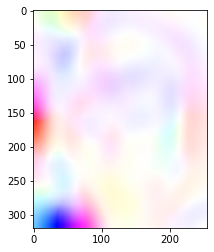

In [20]:
plt.imshow(flow_img)

In [21]:
resized = torch.from_numpy(resized).reshape(2,h,w)
resized.shape

torch.Size([2, 320, 256])

In [22]:
target = label_2.view(1,1,h,w).float()
target.shape

torch.Size([1, 1, 320, 256])

In [23]:
warped_seg_2 = warp(target.cuda(), resized.cuda()).cpu()

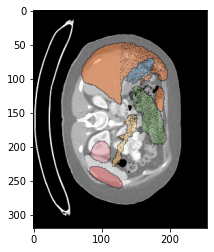

In [24]:
plt.imshow(overlaySegment(test_img_1.squeeze(),warped_seg_2.squeeze() ,False).numpy())

# Exploration 20.05
try to figure out how to upscale the pred_xy from the network

In [1]:
import torch
import torch.nn.functional as F

import numpy as np
import cv2
from math import ceil
import matplotlib.pyplot as plt

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet
from utils.plotting import flow2img

from models.pdd_net.pdd_student import OBELISK2d, deeds2d

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3890: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [2]:
net = OBELISK2d()
reg = deeds2d()

In [3]:
img = torch.load("Data/img.pth")/255
segs = torch.load("Data/seg.pth")

In [57]:
fix = 10; mov = 11
fixed = img[fix:fix+1,:,:] / 255
moving = img[mov:mov+1,:,:] / 255

segs_fixed = segs[fix:fix+1,:,:]
segs_moving = segs[mov:mov+1,:,:]

In [89]:
fixed.shape

torch.Size([1, 320, 256])

In [91]:
inter = F.interpolate(fixed.unsqueeze(0), size=(120,120))

In [92]:
inter.shape

torch.Size([1, 1, 120, 120])

In [95]:
feat00 = net(F.interpolate(fixed.unsqueeze(0), size=(120,120)))
feat50 = net(F.interpolate(moving.unsqueeze(0), size=(120,120)))

cost_soft, pred_xy = reg(feat00,feat50)

In [96]:
cost_soft.shape

torch.Size([1024, 121])

In [97]:
pred_xy.shape

torch.Size([1024, 2])

In [98]:
grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2)

disp_range = 0.25#0.25
displacement_width = 11#15#11#17
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2)

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3890: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [99]:
test = (F.grid_sample(seg_moving,grid_xy+shift_xy,padding_mode='border')\
                          *cost_soft.view(1,-1,32**2,11**2,1)).sum()

RuntimeError: The size of tensor a (1024) must match the size of tensor b (121) at non-singleton dimension 3

In [100]:
seg_moving.shape

torch.Size([1, 8, 320, 256])

In [101]:
a = grid_xy+shift_xy
a.shape

torch.Size([1, 1024, 121, 2])

In [69]:
test1 = F.grid_sample(seg_moving,grid_xy+shift_xy,padding_mode='border')

In [70]:
test1.shape

torch.Size([1, 8, 1024, 121])

In [75]:
test2 = (test1* cost_soft).squeeze()

In [76]:
test2.shape

torch.Size([8, 1024, 121])

In [102]:
test2.view(8,120,-1).shape

RuntimeError: shape '[8, 120, -1]' is invalid for input of size 991232

## Exploration 27.05
explore 3D version

In [5]:
import torch
import torch.nn.functional as F
import torch.nn as nn

In [20]:
imgs = torch.load("Data/img.pth")
H,W,D = imgs.shape

o_m = H//3
o_n = W//3
o_o = D//3
#print('numel_o',o_m*o_n*o_o)
ogrid_xyz = F.affine_grid(torch.eye(3,4).unsqueeze(0),(1,1,o_m,o_n,o_o)).view(1,1,-1,1,3)


class OBELISK(nn.Module):
    def __init__(self):

        super(OBELISK, self).__init__()
        channels = 24#16
        self.offsets = nn.Parameter(torch.randn(2,channels*2,3)*0.05)
        self.layer0 = nn.Conv3d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm3d(4)

        self.layer1 = nn.Conv3d(channels*8, channels*4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm3d(channels*4)
        self.layer2 = nn.Conv3d(channels*4, channels*4, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm3d(channels*4)
        self.layer3 = nn.Conv3d(channels*4, channels*1, 1)


    def forward(self, input_img):
        img_in = F.avg_pool3d(input_img,3,padding=1,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in,ogrid_xyz + self.offsets[0,:,:].view(1,-1,1,1,3)).view(1,-1,o_m,o_n,o_o)
        sampled -= F.grid_sample(img_in,ogrid_xyz + self.offsets[1,:,:].view(1,-1,1,1,3)).view(1,-1,o_m,o_n,o_o)
    
        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features




disp_range = 0.4#0.25
displacement_width = 15#11#17
shift_xyz = F.affine_grid(disp_range*torch.eye(3,4).unsqueeze(0),(1,1,displacement_width,displacement_width,displacement_width)).view(1,1,-1,1,3)#.cuda()

grid_size = 32#25#30
grid_xyz = F.affine_grid(torch.eye(3,4).unsqueeze(0),(1,1,grid_size,grid_size,grid_size)).view(1,-1,1,1,3)#.cuda()

class deeds(nn.Module):
    def __init__(self):

        super(deeds, self).__init__()
        self.alpha = nn.Parameter(torch.Tensor([1,.1,1,1,.1,1]))#.cuda()

        self.pad1 = nn.ReplicationPad3d(3)#.cuda()
        self.avg1 = nn.AvgPool3d(3,stride=1)#.cuda()
        self.max1 = nn.MaxPool3d(3,stride=1)#.cuda()
        self.pad2 = nn.ReplicationPad3d(2)#.cuda()##



    def forward(self, feat00,feat50):
        
        #deeds correlation layer (slightly unrolled)
        deeds_cost = torch.zeros(1,grid_size**3,displacement_width,displacement_width,displacement_width)#.cuda()
        xyz8 = grid_size**2
        for i in range(grid_size): 
            moving_unfold = F.grid_sample(feat50,grid_xyz[:,i*xyz8:(i+1)*xyz8,:,:,:] + shift_xyz,padding_mode='border')
            fixed_grid = F.grid_sample(feat00,grid_xyz[:,i*xyz8:(i+1)*xyz8,:,:,:])
            deeds_cost[:,i*xyz8:(i+1)*xyz8,:,:,:] = self.alpha[1]+self.alpha[0]*torch.sum(torch.pow(fixed_grid-moving_unfold,2),1).view(1,-1,displacement_width,displacement_width,displacement_width)

        # remove mean (not really necessary)
        #deeds_cost = deeds_cost.view(-1,displacement_width**3) - deeds_cost.view(-1,displacement_width**3).mean(1,keepdim=True)[0]
        deeds_cost = deeds_cost.view(1,-1,displacement_width,displacement_width,displacement_width)
    
        # approximate min convolution / displacement compatibility
        cost = self.avg1(self.avg1(-self.max1(-self.pad1(deeds_cost))))
   
        # grid-based mean field inference (one iteration)
        cost_permute = cost.permute(2,3,4,0,1).view(1,displacement_width**3,grid_size,grid_size,grid_size)
        cost_avg = self.avg1(self.avg1(self.pad2(cost_permute))).permute(0,2,3,4,1).view(1,-1,displacement_width,displacement_width,displacement_width)
        
        # second path
        cost = self.alpha[4]+self.alpha[2]*deeds_cost+self.alpha[3]*cost_avg
        cost = self.avg1(self.avg1(-self.max1(-self.pad1(cost))))
        # grid-based mean field inference (one iteration)
        cost_permute = cost.permute(2,3,4,0,1).view(1,displacement_width**3,grid_size,grid_size,grid_size)
        cost_avg = self.avg1(self.avg1(self.pad2(cost_permute))).permute(0,2,3,4,1).view(grid_size**3,displacement_width**3)
        #cost = alpha[4]+alpha[2]*deeds_cost+alpha[3]*cost.view(1,-1,displacement_width,displacement_width,displacement_width)
        #cost = avg1(avg1(-max1(-pad1(cost))))
        
        #probabilistic and continuous output
        cost_soft = F.softmax(-self.alpha[5]*cost_avg,1)
#        pred_xyz = torch.sum(F.softmax(-5self.alpha[2]*cost_avg,1).unsqueeze(2)*shift_xyz.view(1,-1,3),1)
        pred_xyz = torch.sum(cost_soft.unsqueeze(2)*shift_xyz.view(1,-1,3),1)



        return cost_soft,pred_xyz

In [21]:
net = OBELISK()
reg = deeds()

In [22]:
net_weights = torch.load("models/pdd_net/dense_reg_feat_v01.pth")
net_weights.keys()

odict_keys(['offsets', 'layer0.weight', 'batch0.weight', 'batch0.bias', 'batch0.running_mean', 'batch0.running_var', 'batch0.num_batches_tracked', 'layer1.weight', 'batch1.weight', 'batch1.bias', 'batch1.running_mean', 'batch1.running_var', 'batch1.num_batches_tracked', 'layer2.weight', 'batch2.weight', 'batch2.bias', 'batch2.running_mean', 'batch2.running_var', 'batch2.num_batches_tracked', 'layer3.weight', 'layer3.bias'])

In [23]:
net.load_state_dict(net_weights)

RuntimeError: Error(s) in loading state_dict for OBELISK:
	size mismatch for layer1.weight: copying a param with shape torch.Size([48, 48, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([96, 192, 1, 1, 1]).
	size mismatch for batch1.weight: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for batch1.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for batch1.running_mean: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for batch1.running_var: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for layer2.weight: copying a param with shape torch.Size([48, 48, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([96, 96, 3, 3, 3]).
	size mismatch for batch2.weight: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for batch2.bias: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for batch2.running_mean: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for batch2.running_var: copying a param with shape torch.Size([48]) from checkpoint, the shape in current model is torch.Size([96]).
	size mismatch for layer3.weight: copying a param with shape torch.Size([24, 48, 1, 1, 1]) from checkpoint, the shape in current model is torch.Size([24, 96, 1, 1, 1]).

# Explore 01.06.21
reworked Obelisk layer

In [15]:
import torch
from torch import nn
import torch.nn.functional as F

from utils.load_models import init_weights

import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
from utils.plotting import countParameters, flow2img, overlaySegment, showFlow
from utils.layers import warp
from utils.encoding import labelMatrixOneHot, dice_coeff

import cv2
from utils.layers import warp 
from ptflops import get_model_complexity_info

In [7]:
imgs = torch.load("Data/img.pth")
segs = torch.load("Data/seg.pth")

In [8]:
w,h = (320,256)
o_m = h//3
o_n = w//3
ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,o_m,o_n)).view(1,1,-1,2)#.cuda()
disp_range = 0.25#0.25
displacement_width = 15#15#11#17
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2)#.cuda()

grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2)

class OBELISK2d(nn.Module):
	def __init__(self, chan=16):
		super(OBELISK2d, self).__init__()
		channels = chan
		self.offsets = nn.Parameter(torch.randn(2, channels * 2, 2) * 0.05)
		self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
		self.batch0 = nn.BatchNorm2d(4)

		self.layer1 = nn.Conv2d(channels * 8, channels * 4, 1, bias=False, groups=1)
		self.batch1 = nn.BatchNorm2d(channels * 4)
		self.layer2 = nn.Conv2d(channels * 4, channels * 4, 3, bias=False, padding=1)
		self.batch2 = nn.BatchNorm2d(channels * 4)
		self.layer3 = nn.Conv2d(channels * 4, channels * 1, 1)

	def forward(self, input_img):
		img_in = F.avg_pool2d(input_img, 3, padding=1, stride=2)
		img_in = F.relu(self.batch0(self.layer0(img_in)))
		sampled = F.grid_sample(img_in, ogrid_xy + self.offsets[0, :, :].view(1, -1, 1, 2)).view(1, -1, o_m, o_n)
		sampled -= F.grid_sample(img_in, ogrid_xy + self.offsets[1, :, :].view(1, -1, 1, 2)).view(1, -1, o_m, o_n)

		x = F.relu(self.batch1(self.layer1(sampled)))
		x = F.relu(self.batch2(self.layer2(x)))
		features = self.layer3(x)
		return features


class deeds2d(nn.Module):
	def __init__(self):

		super(deeds2d, self).__init__()
		self.alpha = nn.Parameter(torch.Tensor([1 ,.1 ,1 ,1 ,.1 ,1])  )  # .cuda()

		self.pad1 = nn.ReplicationPad2d(3  )  # .cuda()
		self.avg1 = nn.AvgPool2d(3 ,stride=1  )  # .cuda()
		self.max1 = nn.MaxPool2d(3 ,stride=1  )  # .cuda()
		self.pad2 = nn.ReplicationPad2d(2  )  # .cuda()##

	def forward(self, feat00 ,feat50):

		# deeds correlation layer (slightly unrolled)
		deeds_cost = torch.zeros(1 ,grid_size**2 ,displacement_width, displacement_width)#.cuda()

		# print(deeds_cost.shape)
		xy8 = grid_size**2
		# i=1
		# print(grid_xy[:,i*grid_size:(i+1)*grid_size,:,:].shape)
		for i in range(grid_size):
			moving_unfold = F.grid_sample(feat50, grid_xy[: , i *grid_size:( i +1 ) *grid_size ,: ,:] + shift_xy
										  ,padding_mode='border')
			fixed_grid = F.grid_sample(feat00, grid_xy[: , i *grid_size:( i +1 ) *grid_size ,: ,:]) # grid_xy[:,i*xy8:(i+1)*xy8,:,:]
			deeds_cost[: , i *grid_size:( i +1 ) *grid_size ,: ,:] = self.alpha[1 ] +self.alpha[0 ] *torch.sum \
				(torch.pow(fixed_grid -moving_unfold ,2) ,1).view(1 ,-1 ,displacement_width ,displacement_width)


		# remove mean (not really necessary)
		# deeds_cost = deeds_cost.view(-1,displacement_width**3) - deeds_cost.view(-1,displacement_width**3).mean(1,keepdim=True)[0]
		# deeds_cost = deeds_cost.view(1,-1,displacement_width,displacement_width)
		# print(deeds_cost.shape)

		# approximate min convolution / displacement compatibility
		cost = self.avg1(self.avg1(-self.max1(-self.pad1(deeds_cost))))
		# grid-based mean field inference (one iteration)
		cost_permute = cost.permute(2 ,3 ,0 ,1).view(1 ,displacement_width**2 ,grid_size, grid_size)
		cost_avg = self.avg1(self.avg1(self.pad2(cost_permute))).permute(0 ,2 ,3 ,1).view(1 ,-1 ,displacement_width
																						  ,displacement_width)

		# second path
		cost = self.alpha[4 ] +self.alpha[2 ] *deeds_cost +self.alpha[3 ] *cost_avg
		cost = self.avg1(self.avg1(-self.max1(-self.pad1(cost))))

		# grid-based mean field inference (one iteration)
		cost_permute = cost.permute(2 ,3 ,0 ,1).view(1 ,displacement_width**2 ,grid_size ,grid_size)
		cost_avg = self.avg1(self.avg1(self.pad2(cost_permute))).permute(0 ,2 ,3 ,1).view(grid_size**2 ,displacement_width**2)
		# cost = alpha[4]+alpha[2]*deeds_cost+alpha[3]*cost.view(1,-1,displacement_width,displacement_width,displacement_width)
		# cost = avg1(avg1(-max1(-pad1(cost))))

		# probabilistic and continuous output
		cost_soft = F.softmax(-self.alpha[5 ] *cost_avg ,1)
		# pred_xyz = torch.sum(F.softmax(-5self.alpha[2]*cost_avg,1).unsqueeze(2)*shift_xyz.view(1,-1,3),1)
		pred_xy = torch.sum(cost_soft.unsqueeze(2 ) *shift_xy.view(1 ,-1 ,2) ,1)


		return cost_soft ,pred_xy

In [19]:
from torch.autograd import Variable
epochs = 100
lr = 0.005
delta = 0.5

net = OBELISK2d()
init_weights(net)
net.train()

reg = deeds2d()

init_weights(net)

optimizer = torch.optim.Adam(params=list(net.parameters()) + list(reg.parameters()), lr=lr)

disp_range = 0.25#0.25
displacement_width = 15#15#11#17
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2) 
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2)

total_loss = []

kl_loss = torch.nn.KLDivLoss()

torch.manual_seed(10)

pat_indices = torch.cat((torch.arange(0, 17), torch.arange(18, 43)), 0)

rnd_perm_idc = torch.randperm(pat_indices.size(0))
pat_indices = pat_indices[rnd_perm_idc]

# Now, we prepare our train & test dataset.
test_set = torch.LongTensor([35, 41, 0, 4, 39, 17])
train_set = torch.arange(43)
for idx in test_set:
    train_set = train_set[train_set != idx]

diffs = []
for epoch in range(epochs):
     # get training examples
    rnd_train_idx = torch.randperm(train_set.size(0))
    p_fix = train_set[rnd_train_idx[0]]
    p_mov = train_set[rnd_train_idx[1]]

    fixed = imgs[p_fix:p_fix+1,:,:] / 255
    moving = imgs[p_mov:p_mov+1,:,:] / 255
    #Flow output from teacher1
    
    fixed_seg = segs[p_fix:p_fix+1,:,:]
    moving_seg = segs[p_mov:p_mov+1,:,:]
        
    #flow_in = preprocessing_flownet(fixed.reshape(h,w,C),moving.reshape(h,w,C)).cuda()
    #teacher_flow = flow2(flow_in).cpu()
    #warped_moving_teacher = warpImage(labelMatrixOneHot(moving_seg,9), teacher_flow)

    
    optimizer.zero_grad()
    
    fixed = Variable(fixed, requires_grad=True)           #fixed
    moving = Variable(moving, requires_grad=True)         #moving
    
    feat00 = net(fixed.unsqueeze(0))
    feat50 = net(moving.unsqueeze(0))

    # Need some help here. I am not using the soft_cost at all. Not sure how tho
    soft_cost, pred_xy = reg(feat00,feat50)
    
    pred_xy = pred_xy.view(1,grid_size,grid_size,2)
    
    diffloss = 1.5*((pred_xy[0,:,1:,:]-pred_xy[0,:,:-1,:])**2).mean()+\
            1.5*((pred_xy[0,1:,:,:]-pred_xy[0,:-1,:,:])**2).mean()+\
            1.5*((pred_xy[0,:,:,1:]-pred_xy[0,:,:,:-1])**2).mean()
    
    warped_seg = (F.grid_sample(labelMatrixOneHot(moving_seg,9).float(),grid_xy+shift_xy,padding_mode='border')\
                          *soft_cost.view(1,-1,grid_size**2,displacement_width**2)).sum(1,keepdim=True)
    #warped_teacher = F.grid_sample(warped_moving_teacher, grid_xy).detach()

    #teacher_loss = torch.pow((warped_seg - warped_teacher),2).mean()
    
    nonlocal_label = (F.grid_sample(labelMatrixOneHot(moving_seg,9).float(),grid_xy+shift_xy,padding_mode='border')\
                          *soft_cost.view(1,-1,grid_size**2,displacement_width**2)).sum(1,keepdim=True)
    fixed_label = F.grid_sample(labelMatrixOneHot(fixed_seg,9).float(),grid_xy,padding_mode='border')#.long().squeeze(1)

    orig_labelloss = ((nonlocal_label-fixed_label)**2).mean()
    
    
    loss = (diffloss + orig_labelloss) #+ (1-delta)*teacher_loss + delta*orig_labelloss)
    loss.backward()
    diffs.append(loss.item())
    
    #diff.backward()
    #diffs.append(diff.item())
    optimizer.step()

/home/till/envs/anaconda3/envs/uni/lib/python3.9/site-packages/torch/nn/functional.py:3890: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [20]:
net.eval()
reg.eval()

rnd_test_idx = torch.randperm(test_set.size(0))
p_fix = test_set[rnd_test_idx[0]]
p_mov = test_set[rnd_test_idx[1]]

fixed = imgs[p_fix:p_fix+1,:,:] / 255
moving = imgs[p_mov:p_mov+1,:,:] / 255

fixed_seg = segs[p_fix:p_fix+1,:,:]
moving_seg = segs[p_mov:p_mov+1,:,:]

feat1 = net(fixed.unsqueeze(0))
feat2 = net(moving.unsqueeze(0))

soft_cost, pred_xy = reg(feat1,feat2)

dense_flow_fit = F.interpolate(pred_xy.transpose(0,1).view(1,2,grid_size,grid_size),size=(h,w),mode='bicubic')
#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,h,w),align_corners=False)
warped_seg = F.grid_sample(moving_seg.float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False)
d1 = dice_coeff(fixed_seg,warped_seg.squeeze(),9)
print(d1,d1.mean())

tensor([0.0638, 0.0829, 0.0000, 0.0000, 0.2816, 0.0000, 0.0011, 0.0000]) tensor(0.0537)


tensor([0.0638, 0.0829, 0.0000, 0.0000, 0.2816, 0.0000, 0.0011, 0.0000]) tensor(0.0537)


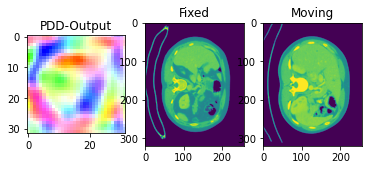

In [21]:
net.eval()
reg.eval()

feat00 = net(fixed.unsqueeze(0))
feat50 = net(moving.unsqueeze(0))

cost_soft, pred_xy = reg(feat00,feat50)
dense_flow_fit = F.interpolate(pred_xy.transpose(0,1).view(1,2,grid_size,grid_size),size=(h,w),mode='bicubic')
#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,h,w),align_corners=False)
warped_seg = F.grid_sample(moving_seg.float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False)
d1 = dice_coeff(fixed_seg,warped_seg.squeeze(),9)
print(d1,d1.mean())

plt.subplot(131)
plt.title("PDD-Output")
plt.imshow(showFlow(pred_xy.transpose(0,1).reshape(2,grid_size,grid_size).detach()))

plt.subplot(132)
plt.title('Fixed')
plt.imshow(fixed.detach().squeeze())

plt.subplot(133)
plt.title('Moving')
plt.imshow(moving.detach().squeeze())

# Student creation with Sequential and Obelisk

In [106]:
import torch
from torch import nn
import torch.nn.functional as F

class OBELISK2d(nn.Module):
    def __init__(self, chan=16, input_size=(100,100)):
        super(OBELISK2d, self).__init__()
        channels = chan
        self.H = input_size[0]
        self.W = input_size[1]
        self.ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,self.H//3,self.W//3)).view(1,1,-1,2)
        
        self.offsets = nn.Parameter(torch.randn(2, channels * 2, 2) * 0.05)
        
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels * 8, channels * 4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels * 4)
        self.layer2 = nn.Conv2d(channels * 4, channels * 4, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels * 4)
        self.layer3 = nn.Conv2d(channels * 4, channels * 1, 1)
        

    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img, 3, padding=1, stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in, self.ogrid_xy + self.offsets[0, :, :].view(1, -1, 1, 2)).view(1, -1, self.H//3, self.W//3)
        sampled -= F.grid_sample(img_in, self.ogrid_xy + self.offsets[1, :, :].view(1, -1, 1, 2)).view(1, -1, self.H//3, self.W//3)

        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features


class PDD(nn.Module):
    def __init__(self, input_size=(100,100), feature_channels=24, sequential = False, displace_range=11, disp_hw=5):
        super(PDD, self).__init__()
        self.displace_range = displace_range
        self.H = input_size[0]
        self.W = input_size[0]
        
        if sequential:
            self.feature_extractor = torch.nn.Sequential(torch.nn.Conv2d(1,32,kernel_size=5,stride=2,padding=4,dilation=2),
                                                         torch.nn.BatchNorm2d(32),
                                                         torch.nn.PReLU(),
                                                         torch.nn.Conv2d(32,32,kernel_size=3,stride=1,padding=1,dilation=1),
                                                         torch.nn.BatchNorm2d(32),
                                                         torch.nn.PReLU(),
                                                         torch.nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1,dilation=1),
                                                         torch.nn.BatchNorm2d(64),
                                                         torch.nn.PReLU(),
                                                         torch.nn.Conv2d(64,feature_channels,kernel_size=1,stride=1,padding=0,dilation=1),
                                                         torch.nn.Sigmoid())
        else:
            self.feature_extractor = OBELISK2d(feature_channels, input_size)
        
    
    def correlation_layer(self,feat_moving, feat_fixed):
    
        disp_hw = (self.displace_range-1)//2
        feat_moving_unfold = F.unfold(feat_moving.transpose(1,0),(self.displace_range,self.displace_range),padding=disp_hw)
        B,C,H,W = feat_fixed.size()

        ssd_distance = ((feat_moving_unfold-feat_fixed.view(C,1,-1))**2).sum(0).view(1,self.displace_range**2,H,W)

        return ssd_distance
    
    def min_convolution(self,ssd_distance, H, W):
        # Prepare operators for smooth dense displacement space
        pad1 = nn.ReplicationPad2d(5)
        avg1 = nn.AvgPool2d(5,stride=1)
        max1 = nn.MaxPool2d(3,stride=1)
        pad2 = nn.ReplicationPad2d(6)
        # approximate min convolution / displacement compatibility

        ssd_minconv = avg1(avg1(-max1(-pad1(ssd_distance.permute(0,2,3,1).reshape(1,-1,self.displace_range,self.displace_range)))))

        print(ssd_minconv.permute(0,2,3,1).shape)
        ssd_minconv = ssd_minconv.permute(0,2,3,1).view(1,-1, H, W)
        min_conv_cost = avg1(avg1(avg1(pad2(ssd_minconv))))

        return min_conv_cost

    def meanfield(self,ssd_distance,img_fixed, H, W):

        crnt_dev = ssd_distance.device

        cost = self.min_convolution(ssd_distance, H, W)
        print(cost.shape)

        soft_cost = F.softmax(-10*cost.view(self.displace_range**2,-1).t(),1)

        disp_hw = (self.displace_range-1)//2
        disp_mesh_grid = disp_hw*F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,self.displace_range,self.displace_range),align_corners=True)
        disp_mesh_grid /= torch.Tensor([(self.W-1)*.5,(self.H-1)*.5])

        disp_xy = torch.sum(soft_cost.view(1,H,W,-1,1)*disp_mesh_grid.view(1,1,1,-1,2).to(crnt_dev),3).permute(0,3,1,2) 

        return soft_cost,disp_xy
    
    
    def forward(self,fixed_img,moving_img):
        
        feat_fixed = self.feature_extractor(fixed_img)
        feat_moving = self.feature_extractor(moving_img)
        
        ssd_distance = self.correlation_layer(feat_moving, feat_fixed)
        soft_cost, pred_xy = self.meanfield(ssd_distance, fixed_img, self.H//4, self.W//4)
        
        return soft_cost, pred_xy

In [107]:
imgs = torch.load('Data/img.pth')
segs = torch.load('Data/seg.pth')
H,W = imgs[0].shape

p_fix = 0
p_mov= 10

test_fixed = imgs[p_fix:p_fix+1,:,:].unsqueeze(0).float() / 255
test_moving = imgs[p_mov:p_mov+1,:,:].unsqueeze(0).float() / 255
pdd = PDD(input_size=(H,W), feature_channels=24, displace_range=11)
pdd(test_fixed,test_moving)

torch.Size([1, 11, 11, 9010])


RuntimeError: shape '[1, -1, 80, 80]' is invalid for input of size 1090210